In [45]:
import simpy
import random
import pandas as pd

# 存储每位乘客的等待时间
waiting_time_list = []
# 当前等待的乘客数量
waiting_passengers = 0
# 计算平均等待时间的时间间隔（15分钟以秒为单位）
time_interval = 15 * 60
# 存储每个时间段的等待时间
waiting_time_intervals = []
# 存储每个时间段的平均等待时间
average_waiting_times = []
# 存储每个时间段的开始时间
time_intervals_start = []

def generate_processing_time():
    # 根据指数分布生成处理时间
    return random.expovariate(1 / 20.0)

def security_check(env, passenger_id, security_lanes):
    global waiting_passengers, waiting_time_intervals

    arrival_time = env.now
    waiting_passengers += 1

    # 选择队列最短的安检通道
    shortest_lane = min(security_lanes, key=lambda x: len(x.queue))
    with shortest_lane.request() as request:
        yield request
        processing_start = env.now
        yield env.timeout(generate_processing_time())
        waiting_time = env.now - arrival_time
        waiting_time_list.append(waiting_time)
        waiting_passengers -= 1
        waiting_time_intervals[-1].append(waiting_time)
        print(f"乘客{passenger_id}于{arrival_time}到达")
        print(f"乘客{passenger_id}于{env.now}完成安检（等待时间：{waiting_time}秒）")

def passenger_generator(env, security_lanes, passengers_data):
    for _, passenger in passengers_data.iterrows():
        passenger_id = passenger['Id']
        arrival_time = passenger['ArrivalTime']
        yield env.timeout(arrival_time - env.now)
        env.process(security_check(env, passenger_id, security_lanes))

def adjust_security_lanes(env, security_lanes, security_data):
    for _, row in security_data.iterrows():
        time, lanes = row['Time'], row['Lanes']
        yield env.timeout(time - env.now)
        # 调整活动通道的数量
        while len(security_lanes) < lanes:
            security_lanes.append(simpy.Resource(env, capacity=1))
        while len(security_lanes) > lanes:
            security_lanes.pop()

def calculate_average_waiting_time(env):
    global time_intervals_start
    current_time = 0
    while True:
        yield env.timeout(time_interval)
        current_time += time_interval
        if waiting_time_intervals[-1]:
            avg_waiting_time = sum(waiting_time_intervals[-1]) / len(waiting_time_intervals[-1])
            average_waiting_times.append(avg_waiting_time)
        else:
            average_waiting_times.append(0)
        time_intervals_start.append(current_time - time_interval)
        waiting_time_intervals.append([])
        
def reset_globals():
    global waiting_time_list, waiting_passengers, waiting_time_intervals, average_waiting_times, time_intervals_start
    waiting_time_list = []
    waiting_passengers = 0
    waiting_time_intervals = [[]]
    average_waiting_times = []
    time_intervals_start = []
    
def run_simulation(sim_time, passengers_data, security_data):
    reset_globals()

    env = simpy.Environment()
    initial_lanes = security_data['Lanes'].iloc[0]
    security_lanes = [simpy.Resource(env, capacity=1) for _ in range(initial_lanes)]
    waiting_time_intervals.append([])

    env.process(passenger_generator(env, security_lanes, passengers_data))
    env.process(adjust_security_lanes(env, security_lanes, security_data))
    env.process(calculate_average_waiting_time(env))
    
    env.run(until=sim_time)
    df_avg_waiting_times = pd.DataFrame({'Average Waiting Time': average_waiting_times}, index=time_intervals_start)
    return df_avg_waiting_times

def multiple_run_simulation(runs, sim_time, passengers_data, security_data):
    total_avg_waiting_times = None
    for i in range(runs):
        print(f"正在运行模拟 {i+1}/{runs}")
        average_waiting_time_df = run_simulation(sim_time, passengers_data, security_data)
        if total_avg_waiting_times is None:
            total_avg_waiting_times = average_waiting_time_df
        else:
            # 逐行合并数据，计算平均值
            total_avg_waiting_times = total_avg_waiting_times.add(average_waiting_time_df, fill_value=0)

    # 计算所有模拟的总体平均等待时间
    overall_average = total_avg_waiting_times / runs
    return overall_average

# 数据导入
passengers_data = pd.read_csv('passengers_0.csv').sort_values(by='ArrivalTime')
security_data = pd.read_csv('security.csv')

# 运行多次模拟
simulation_result_df = multiple_run_simulation(20, 40000, passengers_data, security_data)
print(simulation_result_df)



正在运行模拟 1/20
乘客7W4SUIW8P60C9EZHVKY7于8233.11798182214到达
乘客7W4SUIW8P60C9EZHVKY7于8235.649086979536完成安检（等待时间：2.531105157395359秒）
乘客TGR0H5TWSF84MFMQUX8C于8276.390512008185到达
乘客TGR0H5TWSF84MFMQUX8C于8281.839759644565完成安检（等待时间：5.4492476363793685秒）
乘客9U7304Z48YAGBHLRQ2C1于8868.483377069739到达
乘客9U7304Z48YAGBHLRQ2C1于8873.558616148133完成安检（等待时间：5.075239078394588秒）
乘客KMIZ1FTYWSB0LAQWT1YX于8892.912111878226到达
乘客KMIZ1FTYWSB0LAQWT1YX于8920.665797770103完成安检（等待时间：27.753685891877467秒）
乘客EH1RELRCS1FWEAKAN0XN于9024.329169188到达
乘客EH1RELRCS1FWEAKAN0XN于9039.45340692472完成安检（等待时间：15.124237736719806秒）
乘客NV7KUEARJML65WN17FCG于9106.285121659166到达
乘客NV7KUEARJML65WN17FCG于9144.37210669484完成安检（等待时间：38.08698503567393秒）
乘客5PPT0WWE5IP8IFFGFLJH于10188.54801089032到达
乘客5PPT0WWE5IP8IFFGFLJH于10206.111989318759完成安检（等待时间：17.56397842843944秒）
乘客ZJ61OIMBSX93FYQ8URVD于10345.716468004674到达
乘客ZJ61OIMBSX93FYQ8URVD于10360.205332803149完成安检（等待时间：14.488864798475333秒）
乘客EFVX4UN9YTAC9KH8O36P于10668.546221785446到达
乘客EFVX4UN9YTAC9KH8O36P于10673.1194114064

In [47]:
non_zero_values = overall_average_waiting_time_df[average_waiting_time_df['Average Waiting Time'] != 0]
non_zero_count = non_zero_values['Average Waiting Time'].count()
overall_average_waiting_time_df['Average Waiting Time'].sum()/non_zero_count

226.1992464197147

In [48]:
overall_average_waiting_time_df["Time in hour"] = average_waiting_time_df.index/3600
overall_average_waiting_time_df

Average Waiting Time  Time in hour
0                  0.000000          0.00
900                0.000000          0.25
1800               0.000000          0.50
2700               0.000000          0.75
3600               0.000000          1.00
4500               0.000000          1.25
5400               0.000000          1.50
6300               0.000000          1.75
7200               0.000000          2.00
8100              19.696620          2.25
9000              20.183797          2.50
9900              10.584104          2.75
10800             23.050107          3.00
11700             32.162796          3.25
12600             49.893129          3.50
13500             34.669648          3.75
14400             35.602671          4.00
15300             54.177123          4.25
16200            132.577854          4.50
17100            309.880689          4.75
18000            340.596706          5.00
18900            266.609739          5.25
19800             66.920696          5.50
20700             29.151138          5.75
21600             45.217590          6.00
22500             26.932938          6.25
23400             34.787913          6.50
24300             26.820222          6.75
25200             50.761625          7.00
26100             57.915278          7.25
27000             66.221844          7.50
27900            112.071150          7.75
28800            220.290871          8.00
29700            372.004878          8.25
30600            575.296600          8.50
31500            860.000338          8.75
32400           1016.841576          9.00
33300           1072.442637          9.25
34200            883.990128          9.50
35100            366.071526          9.75
36000             24.951954         10.00
36900              0.000000         10.25
37800              0.000000         10.50
38700              0.000000         10.75

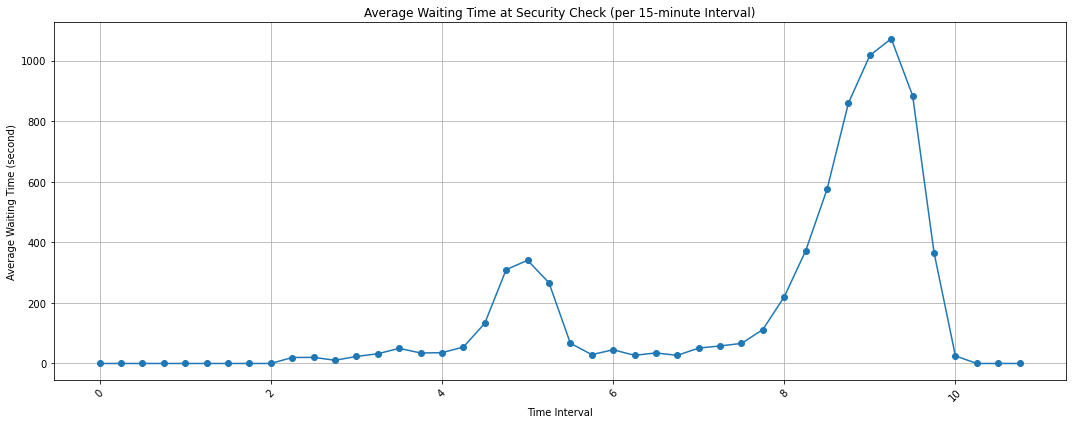

In [49]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(15, 6))
plt.plot(overall_average_waiting_time_df['Time in hour'], overall_average_waiting_time_df['Average Waiting Time'], marker='o')
plt.title('Average Waiting Time at Security Check (per 15-minute Interval)')
plt.xlabel('Time Interval')
plt.ylabel('Average Waiting Time (second)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()